# Installing Necessary Packages and Import

In [2]:
!pip install tensorflow==2.13.0

  Obtaining dependency information for tensorflow==2.13.0 from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/2f/2f/3c84f675931ce3bcbc7e23acbba1e5d7f05ce769adab48322de57a9f5928/tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Obtaining dependency information for h5py>=2.9.0 from https://files.pythonhosted.org/packages/d1/93/0f4cf5058095d749d464e4f770d2bf339930e5f3374331f0d2fa6

# Imports

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import time
from PIL import Image
from random import randint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG # Data augmentation için
from tensorflow.keras.preprocessing import image

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report # Confusion matrisi için
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.13.0


# Data Preprocessing

In [16]:
levels =  ["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]
path = "Dataset"
data_dir = os.path.join(path)
data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'AD_result'])

data['path'] = path + '/' + data['image_file']
data['AD_result'] = data['AD_result'].map({'Non_Demented':'Non Demented', 'Very_Mild_Demented':'Very Mild Demented', 
                                           'Mild_Demented':'Mild Demented', 'Moderate_Demented':'Moderate Demented'})
samples = 6400

data.head()

,image_file,AD_result,path
0,Non_Demented/non.jpg,Non Demented,Dataset/Non_Demented/non.jpg
1,Non_Demented/non_10.jpg,Non Demented,Dataset/Non_Demented/non_10.jpg
2,Non_Demented/non_100.jpg,Non Demented,Dataset/Non_Demented/non_100.jpg
3,Non_Demented/non_1000.jpg,Non Demented,Dataset/Non_Demented/non_1000.jpg
4,Non_Demented/non_1001.jpg,Non Demented,Dataset/Non_Demented/non_1001.jpg


In [17]:
print('Number of Repeated Samples: %d'%(data.duplicated().sum()))
print('Total Number of Samples: %d'%(data.isnull().value_counts()))

Number of Repeated Samples: 0
Total Number of Samples: 6400


C:\Users\siddh\AppData\Local\Temp\ipykernel_34060\1778716696.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('Total Number of Samples: %d'%(data.isnull().value_counts()))


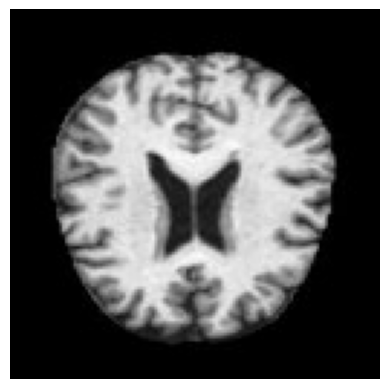

In [18]:
plt.figure()
img = cv2.imread(data['path'][0])
plt.imshow(img)
plt.axis('off')
plt.show() 

The image under review is an MR image but has 3 channels, so this image is in RGB scale. In short, the image we are examining is in RGB scale, even if it is an X-Ray image.

# Data Preparation

In [19]:
data_src="Dataset/"

In [20]:
data=[]
labels=[]

for d in os.listdir(data_src):
    for file in os.listdir(data_src+d):
        data.append(Image.open(data_src+d+'/'+file))
        labels.append(d)

In [21]:
# Convert each image into a numpy array
images=[]
for im in data:
    images.append(np.array(im))

#Convert the list of data into an array
images=np.array(images)

images.shape

(6400, 128, 128)

In [22]:
#Divide by 255 to standardize the values between 0 and 1
images=images/255

In [23]:
#Let's count how many of each category we have
non_demented = 0
mild_demented = 0
moderate_demented = 0
very_mild_demented = 0
for i in labels:
    if i=="Mild_Demented":
        mild_demented +=1
    elif i=="Moderate_Demented":
        moderate_demented +=1
    elif i=="Non_Demented":
        non_demented +=1
    else:
        very_mild_demented +=1
print("Non Demented: ", non_demented)
print("Very Mild: ",very_mild_demented)
print("Moderate: ",moderate_demented)
print("Mild :",mild_demented)

Non Demented:  3200
Very Mild:  2240
Moderate:  64
Mild : 896


In [24]:
#Now we change these values to numerical ones so that we can use to_categorical
#0 will be non, 1 will be very mild, 2 will be mild, 3 will be moderate
labels_num=[]

for i in labels:
    if i=="Mild_Demented":
        labels_num.append(2)
    elif i=="Moderate_Demented":
        labels_num.append(3)
    elif i=="Non_Demented":
        labels_num.append(0)
    else:
        labels_num.append(1)

#convert to a categorical target as expected by keras
labels=to_categorical(labels_num)  

labels.shape

(6400, 4)

In [25]:
#Reshape images to use in a neural network
images=images.reshape(6400,128,128,1)

In [26]:
#Split into a training set and test set
train_data, test_data, train_label, test_label = train_test_split(images,labels,test_size=0.25,random_state=42)

In [27]:
print(train_data.shape, test_data.shape, train_label.shape, test_label.shape)

(4800, 128, 128, 1) (1600, 128, 128, 1) (4800, 4) (1600, 4)


In [28]:
train_data.shape[1:]

(128, 128, 1)

# Creating and Training the Model

In [29]:
#Create the model
cnn = Sequential()
cnn.add(Conv2D(64,(3,3),
                padding="same",
                activation='relu',
                input_shape=train_data.shape[1:]))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(64,(3,3),
               padding="same",
               activation='relu'))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32,(2,2),
               padding="same",
               activation='relu'))
cnn.add(MaxPooling2D())

cnn.add(Flatten())
cnn.add(Dense(100,activation='relu'))
cnn.add(Dense(4,activation='softmax'))

In [30]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

In [31]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

In [33]:
#Train the Convolutional Neural Network on the data
start_time = time.time()
history=cnn.fit(train_data, train_label, 
                epochs=20,
                validation_data=(test_data,test_label))
end_time = time.time()

Epoch 1/20
150/150 [==============================] - 232s 2s/step - loss: 0.9852 - accuracy: 0.5275 - val_loss: 0.8905 - val_accuracy: 0.5688
Epoch 2/20
150/150 [==============================] - 225s 1s/step - loss: 0.8370 - accuracy: 0.6185 - val_loss: 0.7840 - val_accuracy: 0.6300
Epoch 3/20
150/150 [==============================] - 234s 2s/step - loss: 0.6622 - accuracy: 0.7158 - val_loss: 0.6521 - val_accuracy: 0.7156
Epoch 4/20
150/150 [==============================] - 179s 1s/step - loss: 0.4557 - accuracy: 0.8065 - val_loss: 0.4435 - val_accuracy: 0.8119
Epoch 5/20
150/150 [==============================] - 160s 1s/step - loss: 0.3070 - accuracy: 0.8748 - val_loss: 0.2797 - val_accuracy: 0.8963
Epoch 6/20
150/150 [==============================] - 556s 4s/step - loss: 0.1643 - accuracy: 0.9404 - val_loss: 0.2127 - val_accuracy: 0.9212
Epoch 7/20
150/150 [==============================] - 235s 2s/step - loss: 0.0938 - accuracy: 0.9710 - val_loss: 0.1599 - val_accuracy: 0.9488

In [34]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
print(f"Execution time: {execution_time/60} minutes")

Execution time: 4283.033676624298 seconds
Execution time: 71.38389461040497 minutes


<b> As you can see, without Intel Optimizations, the time taken for training such a large dataset took 4283.03 seconds (71.38 mins) and the accuracy is also comparatively a bit less.

# Model Evaluation


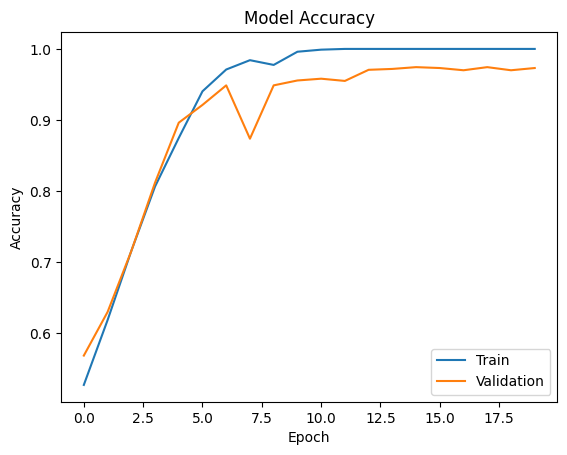

In [35]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

In [36]:
#Get a prediction from the neural network
y_pred=cnn.predict(test_data)

50/50 [==============================] - 9s 177ms/step


In [37]:
#The prediction is a sequence of 4 probabilities. We choose the label with the highest probability.
y_val=[]
for y in y_pred:
    y_val.append(np.argmax(y))

In [38]:
#Convert back to labels 0-3
y_true=[]
for y in test_label:
    y_true.append(np.argmax(y))

In [39]:
#Let's see how the predictions did
print(confusion_matrix(y_true,y_val))

[[797  15   2   0]
 [ 18 513   2   0]
 [  3   3 235   0]
 [  0   0   0  12]]


In [40]:
cm = confusion_matrix(y_true,y_val)

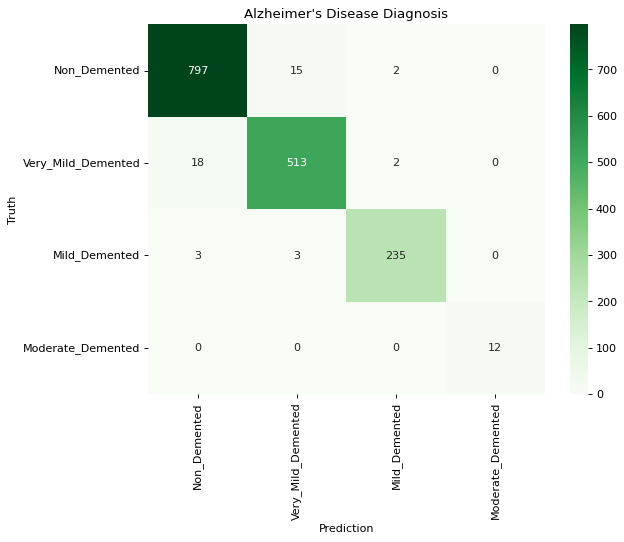

In [41]:
Labels = ["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=Labels, yticklabels=Labels)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [42]:
print("Classification Report")
print(classification_report(y_true,y_val))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       814
           1       0.97      0.96      0.96       533
           2       0.98      0.98      0.98       241
           3       1.00      1.00      1.00        12

    accuracy                           0.97      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.97      0.97      0.97      1600



In [43]:
print("Accuracy on test data: ",accuracy_score(y_true,y_val))

Accuracy on test data:  0.973125


# Testing the Model

In [44]:

submission = pd.DataFrame(list(zip(y_val, y_true)))
submission.columns =['Predictions', 'Actual']
submission.to_csv("submission.csv", index=False)

In [45]:

def show_image(img_path):
  img = mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  return plt.show()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 

In [46]:
from tensorflow.keras.preprocessing import image
Labels = ['Non_Demented', 'Very_Mild_Demented', 'Mild_Demented', 'Moderate_Demented']

def predict_label(img_path):
    test_image = Image.open(img_path).convert('L')
    test_image = image.img_to_array(test_image)/255.0
    test_image = test_image.reshape(-1,128,128,1)
    predict_x= cnn.predict(test_image) 
    classes_x=np.argmax(predict_x,axis=1)
    return show_image(img_path), Labels[classes_x[0]]

1/1 [==============================] - 0s 132ms/step


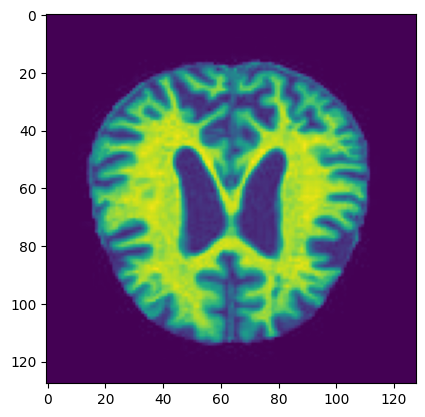

(None, 'Moderate_Demented')

In [47]:
predict_label('Dataset/Moderate_Demented/moderate_11.jpg')

# Saving the Model

In [48]:
#Saving the model for future use
work_dir = "Dataset/"
model_dir = work_dir + "alzheimer_cnn_model"
cnn.save(model_dir, save_format='h5')
os.listdir(work_dir)

C:\Users\siddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['alzheimer_cnn_model',
 'Mild_Demented',
 'Moderate_Demented',
 'Non_Demented',
 'Very_Mild_Demented']